In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset
from gensim.models import Word2Vec
from models import CNNClassifier, RNNClassifier, GRUClassifier, LSTMClassifier, TClassifier
from training_function import training
from config_dataset import custom_dataset
from accuracy import classifier_accuracy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
sequence_length = 20
batch_size = 32
embedding_dim = 300
hidden_dim = 8

In [5]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size, style0_test, style1_test, style2_test = custom_dataset('text_corpus/divina_commedia.txt',
                                                                                                                                                        'text_corpus/uno_nessuno_e_i_malavoglia.txt',
                                                                                                                                                        'text_corpus/lo_cunto_de_li_cunti.txt',
                                                                                                                                                        sequence_length,
                                                                                                                                                        embedding_dim,
                                                                                                                                                        batch_size,
                                                                                                                                                        0.8)
print('len train loader: ', len(train_loader))
print('len val loader: ', len(val_loader))
print('total number of training samples: ', len(train_loader.dataset))
print('total number of validation samples: ', len(val_loader.dataset))
print('vocab size: ', vocab_size)

len train loader:  352
len val loader:  44
total number of training samples:  11248
total number of validation samples:  1405
vocab size:  26607


# CNN Classifier

In [6]:
cnn_classifier = CNNClassifier(embedding_matrix, 3, 3, [3,3,3])

In [7]:
classifier_params = sum(p.numel() for p in cnn_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  8139


 12%|█▎        | 1/8 [00:01<00:11,  1.58s/it]

====> Epoch: 1 Average train loss: 0.0213, Average val loss: 0.0184


 25%|██▌       | 2/8 [00:02<00:08,  1.43s/it]

====> Epoch: 2 Average train loss: 0.0183, Average val loss: 0.0181


 38%|███▊      | 3/8 [00:04<00:07,  1.41s/it]

====> Epoch: 3 Average train loss: 0.0179, Average val loss: 0.0179


 50%|█████     | 4/8 [00:05<00:05,  1.40s/it]

====> Epoch: 4 Average train loss: 0.0178, Average val loss: 0.0179


 62%|██████▎   | 5/8 [00:07<00:04,  1.38s/it]

====> Epoch: 5 Average train loss: 0.0177, Average val loss: 0.0178


 75%|███████▌  | 6/8 [00:08<00:02,  1.34s/it]

====> Epoch: 6 Average train loss: 0.0176, Average val loss: 0.0178


 88%|████████▊ | 7/8 [00:09<00:01,  1.32s/it]

====> Epoch: 7 Average train loss: 0.0175, Average val loss: 0.0178


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]

====> Epoch: 8 Average train loss: 0.0175, Average val loss: 0.0178


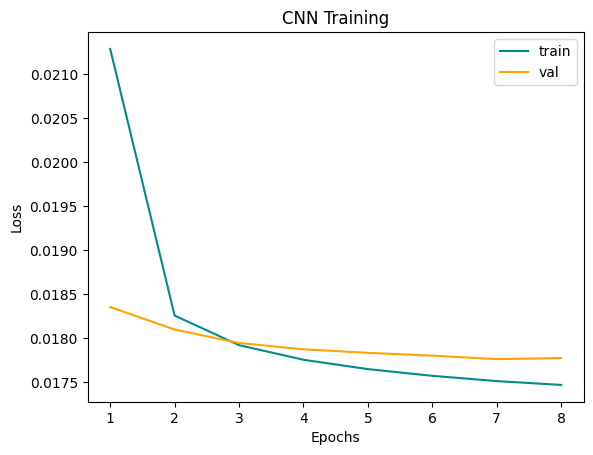

In [8]:
train_losses = training(cnn_classifier, train_loader, val_loader, 8, 4e-4, 'CNN Training')

### Examples with CNN 

In [143]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = cnn_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  2 ,  Napoletano
Predicted Style:  2 with probability:  57.61168599128723 %
Input sequence: 
 io non tanto averraggio tormiento de scrastareme da sto nigro cuorpo quanto de scantoniareme da ssa bella perzona cossì dicendo


# CNN Classifier Accuracy

In [10]:
classifier_accuracy(cnn_classifier, style0_test, style1_test, style2_test, 'CNN')

Accuracy predicting Dante:  0.9752212389380531
Accuracy predicting Italian:  0.9982300884955753
Accuracy predicting Neapolitan:  1.0
Overall  CNN  Accuracy:  0.9911504424778762


# RNN Classifier

In [15]:
rnn_classifier = RNNClassifier(embedding_matrix, hidden_dim, 1)

In [16]:
classifier_params = sum(p.numel() for p in rnn_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  3107


 10%|█         | 1/10 [00:00<00:08,  1.10it/s]

====> Epoch: 1 Average train loss: 0.0311, Average val loss: 0.0274


 20%|██        | 2/10 [00:01<00:07,  1.09it/s]

====> Epoch: 2 Average train loss: 0.0246, Average val loss: 0.0227


 30%|███       | 3/10 [00:02<00:06,  1.02it/s]

====> Epoch: 3 Average train loss: 0.0207, Average val loss: 0.0192


 40%|████      | 4/10 [00:03<00:05,  1.07it/s]

====> Epoch: 4 Average train loss: 0.0174, Average val loss: 0.0164


 50%|█████     | 5/10 [00:04<00:04,  1.09it/s]

====> Epoch: 5 Average train loss: 0.0147, Average val loss: 0.0139


 60%|██████    | 6/10 [00:05<00:03,  1.12it/s]

====> Epoch: 6 Average train loss: 0.0121, Average val loss: 0.0113


 70%|███████   | 7/10 [00:06<00:02,  1.08it/s]

====> Epoch: 7 Average train loss: 0.0094, Average val loss: 0.0090


 80%|████████  | 8/10 [00:07<00:01,  1.12it/s]

====> Epoch: 8 Average train loss: 0.0067, Average val loss: 0.0065


 90%|█████████ | 9/10 [00:08<00:00,  1.14it/s]

====> Epoch: 9 Average train loss: 0.0065, Average val loss: 0.0075


100%|██████████| 10/10 [00:08<00:00,  1.11it/s]

====> Epoch: 10 Average train loss: 0.0057, Average val loss: 0.0058


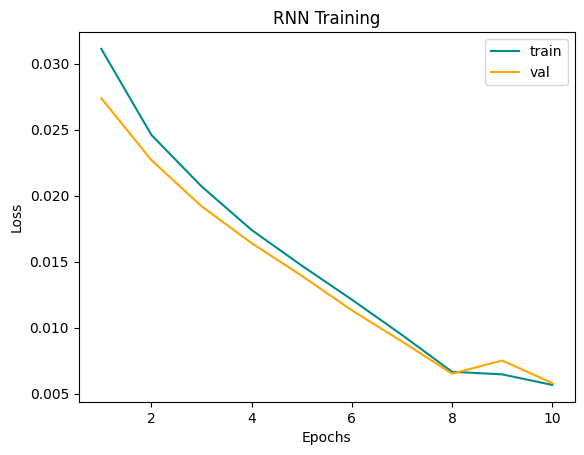

In [17]:
train_losses = training(rnn_classifier, train_loader, val_loader, 10, 4e-4, 'RNN Training')

In [153]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = rnn_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  2 ,  Napoletano
Predicted Style:  2 with probability:  96.19741439819336 %
Input sequence: 
 ve la dicere comme sta restava de mala voglia a sto pajese ma pocca lo cielo me l ha mannata


# RNN Classifier Accuracy

In [18]:
classifier_accuracy(rnn_classifier, style0_test, style1_test, style2_test, 'RNN')

Accuracy predicting Dante:  0.9380530973451328
Accuracy predicting Italian:  0.9557522123893806
Accuracy predicting Neapolitan:  0.9424460431654677
Overall  RNN  Accuracy:  0.945417117633327


# GRU Classifier

In [20]:
gru_classifier = GRUClassifier(embedding_matrix, hidden_dim, 1)

In [21]:
classifier_params = sum(p.numel() for p in gru_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  8067


 10%|█         | 1/10 [00:01<00:16,  1.78s/it]

====> Epoch: 1 Average train loss: 0.0283, Average val loss: 0.0233


 20%|██        | 2/10 [00:03<00:14,  1.77s/it]

====> Epoch: 2 Average train loss: 0.0179, Average val loss: 0.0145


 30%|███       | 3/10 [00:05<00:12,  1.72s/it]

====> Epoch: 3 Average train loss: 0.0101, Average val loss: 0.0081


 40%|████      | 4/10 [00:06<00:10,  1.73s/it]

====> Epoch: 4 Average train loss: 0.0058, Average val loss: 0.0053


 50%|█████     | 5/10 [00:08<00:08,  1.75s/it]

====> Epoch: 5 Average train loss: 0.0039, Average val loss: 0.0040


 60%|██████    | 6/10 [00:10<00:07,  1.83s/it]

====> Epoch: 6 Average train loss: 0.0029, Average val loss: 0.0032


 70%|███████   | 7/10 [00:12<00:05,  1.85s/it]

====> Epoch: 7 Average train loss: 0.0022, Average val loss: 0.0028


 80%|████████  | 8/10 [00:14<00:03,  1.82s/it]

====> Epoch: 8 Average train loss: 0.0017, Average val loss: 0.0023


 90%|█████████ | 9/10 [00:16<00:01,  1.81s/it]

====> Epoch: 9 Average train loss: 0.0013, Average val loss: 0.0021


100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

====> Epoch: 10 Average train loss: 0.0011, Average val loss: 0.0022


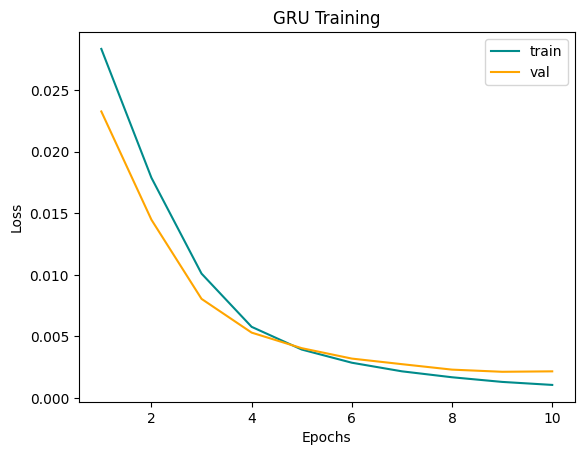

In [22]:
train_losses = training(gru_classifier, train_loader, val_loader, 10, 4e-4, 'GRU Training')

In [154]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = gru_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  0 ,  Dante
Predicted Style:  0 with probability:  99.8595654964447 %
Input sequence: 
 parente già era l caponsacco nel mercato disceso giù da fiesole e già era buon cittadino giuda e infangato io


# GRU Classifier Accuracy

In [23]:
classifier_accuracy(gru_classifier, style0_test, style1_test, style2_test, 'GRU')

Accuracy predicting Dante:  0.9663716814159292
Accuracy predicting Italian:  0.9911504424778761
Accuracy predicting Neapolitan:  0.9856115107913669
Overall  GRU  Accuracy:  0.9810445448950574


# LSTM Classifier

In [25]:
lstm_classifier = LSTMClassifier(embedding_matrix, hidden_dim, 1)

In [26]:
classifier_params = sum(p.numel() for p in lstm_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  10547


 10%|█         | 1/10 [00:00<00:08,  1.05it/s]

====> Epoch: 1 Average train loss: 0.0300, Average val loss: 0.0216


 20%|██        | 2/10 [00:01<00:06,  1.18it/s]

====> Epoch: 2 Average train loss: 0.0112, Average val loss: 0.0051


 30%|███       | 3/10 [00:02<00:05,  1.29it/s]

====> Epoch: 3 Average train loss: 0.0039, Average val loss: 0.0030


 40%|████      | 4/10 [00:03<00:04,  1.29it/s]

====> Epoch: 4 Average train loss: 0.0024, Average val loss: 0.0023


 50%|█████     | 5/10 [00:03<00:03,  1.32it/s]

====> Epoch: 5 Average train loss: 0.0018, Average val loss: 0.0018


 60%|██████    | 6/10 [00:04<00:03,  1.29it/s]

====> Epoch: 6 Average train loss: 0.0014, Average val loss: 0.0017


 70%|███████   | 7/10 [00:05<00:02,  1.32it/s]

====> Epoch: 7 Average train loss: 0.0011, Average val loss: 0.0016


 80%|████████  | 8/10 [00:06<00:01,  1.35it/s]

====> Epoch: 8 Average train loss: 0.0009, Average val loss: 0.0014


 90%|█████████ | 9/10 [00:07<00:00,  1.28it/s]

====> Epoch: 9 Average train loss: 0.0008, Average val loss: 0.0014


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]

====> Epoch: 10 Average train loss: 0.0007, Average val loss: 0.0015


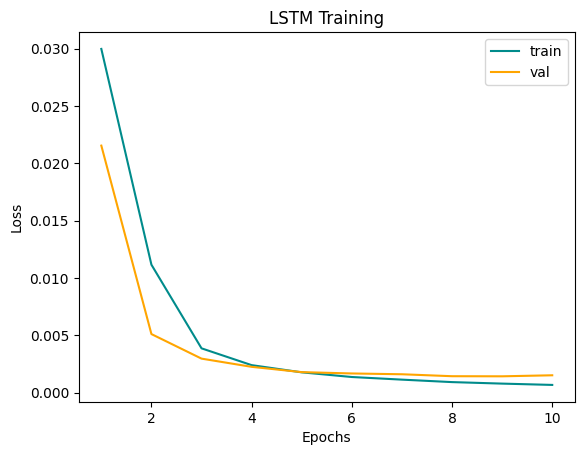

In [27]:
train_losses = training(lstm_classifier, train_loader, val_loader, 10, 4e-4, 'LSTM Training')

In [159]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = lstm_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  0 ,  Dante
Predicted Style:  0 with probability:  99.85785484313965 %
Input sequence: 
 menti non capere in triangol due ottusi così vedi le cose contingenti anzi che sieno in sè mirando il punto


# LSTM Accuracy

In [28]:
classifier_accuracy(lstm_classifier, style0_test, style1_test, style2_test, 'LSTM')

Accuracy predicting Dante:  0.9858407079646018
Accuracy predicting Italian:  0.9876106194690265
Accuracy predicting Neapolitan:  0.9820143884892086
Overall  LSTM  Accuracy:  0.9851552386409456


# Transformer Classifier

In [30]:
t_classifier = TClassifier(embedding_matrix, hidden_dim, 1)

In [31]:
classifier_params = sum(p.numel() for p in t_classifier.parameters() if p.requires_grad)
print('# Parameters: ', classifier_params)

# Parameters:  3188599


 20%|██        | 1/5 [00:14<00:59, 14.83s/it]

====> Epoch: 1 Average train loss: 0.0015, Average val loss: 0.0007


 40%|████      | 2/5 [00:29<00:44, 14.84s/it]

====> Epoch: 2 Average train loss: 0.0005, Average val loss: 0.0012


 60%|██████    | 3/5 [00:48<00:33, 16.69s/it]

====> Epoch: 3 Average train loss: 0.0003, Average val loss: 0.0008


 80%|████████  | 4/5 [01:04<00:16, 16.45s/it]

====> Epoch: 4 Average train loss: 0.0001, Average val loss: 0.0011


100%|██████████| 5/5 [01:20<00:00, 16.14s/it]

====> Epoch: 5 Average train loss: 0.0000, Average val loss: 0.0011


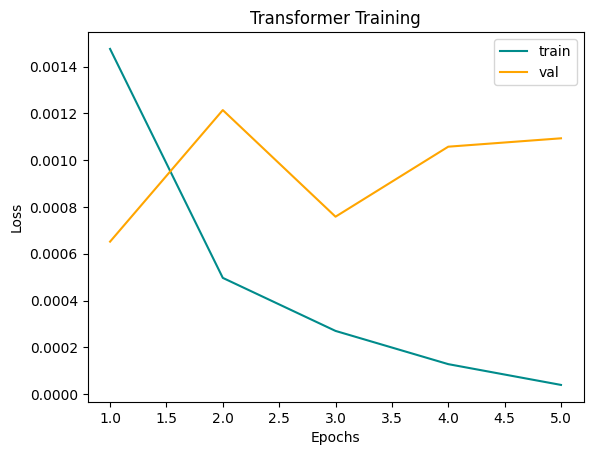

In [32]:
train_losses = training(t_classifier, train_loader, val_loader, 5, 4e-4, 'Transformer Training')

In [164]:
for i ,(data, label) in enumerate(val_loader):
    if i == 0:
        prova = data[0]
        labels = label[0]
    else: 
        break

input_sentence = [idx2word[prova[i].item()] for i in range(prova.shape[0])]

prova = prova.view(1,prova.shape[0])

with torch.no_grad():
    pred_label = t_classifier(prova)
    
pred_label = torch.softmax(pred_label, dim = -1)


if labels == 0.0:
    stile = 'Dante'
elif labels == 1.0:
    stile = 'Italiano'
elif labels == 2.0:
    stile = 'Napoletano'


pred_style = torch.argmax(pred_label).item()
print('Real Style: ', labels.item(), ', ', stile)
print('Predicted Style: ', pred_style, 'with probability: ', pred_label[0][0][pred_style].item()*100, '%')
print("Input sequence: \n", ' '.join(input_sentence))

Real Style:  0 ,  Dante
Predicted Style:  0 with probability:  99.9979019165039 %
Input sequence: 
 t eran possenti il nome del bel fior ch io sempre invoco e mane e sera tutto mi ristrinse l


# Transformer Classifier Accuracy

In [35]:
classifier_accuracy(t_classifier, style0_test, style1_test, style2_test, 'Transformer')

Accuracy predicting Dante:  0.9911504424778761
Accuracy predicting Italian:  0.9929203539823008
Accuracy predicting Neapolitan:  1.0
Overall  Transformer  Accuracy:  0.9946902654867257
